<div class="alert alert-block alert-success"><font color="black"><h1><left>EDA of MIMIC ICU Data for Intestinal Conditions</left></h1></font></div>


In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re

In [3]:
# File definitions
path = 'E:\Education\DataScience\CCSU-Data-Science\Data-Mining-And-Predictive-Analytics\Data-531\Data\\'
file1 = path + 'part-00000-diagnosis-code.snappy.parquet'
file2 = path + 'part-00000-admission-diags.snappy.parquet'
file3 = path + 'part-00000-admissions.snappy.parquet'
file4 = path + 'part-00000-note-events.snappy.parquet'
file5 = path + 'part-00000-chart-events.snappy.parquet'
file6 = path + 'part-00000-icu-stays.snappy.parquet'
file8 = path + 'part-00000-procedure-icd-snappy.parquet'
file9 = path + 'notes-12-6.snappy.parquet'
file7 = path + 'ICD10_Formatted.csv'

<div class="alert alert-block alert-success"><font color="black"><h1><left>Generate Core Dataframes</left></h1></font></div>


In [4]:
diag_codes = pd.read_parquet(file1,engine='auto',use_nullable_dtypes=True)
admsn_diags = pd.read_parquet(file2,engine='auto',use_nullable_dtypes=True)
# proc_icd = pd.read_parquet(file8,engine='auto',use_nullable_dtypes=True)
admissions = pd.read_parquet(file3,engine='auto',use_nullable_dtypes=True)\
#             [['hadm_id','subject_id','admittime', 'dischtime','diagnosis']]
# notes = pd.read_parquet(file4,engine='auto',use_nullable_dtypes=True)
# cevents = pd.read_parquet(file5,engine='auto',use_nullable_dtypes=True)


<div class="alert alert-block alert-success"><font color="black"><h2><left>Read ICD9 to ICD10 Translatiion file</left></h2></font></div>


In [5]:
import re

icd9_df = pd.read_csv(file7,sep='|', header=0)
icd9_df['ICD9'] = icd9_df['ICD9'].astype(str).apply(lambda x: re.sub('\.','', x))
icd9_df[1:5]

,ICD9,ICD10,Description
1,0011,A00.1,"Cholera due to Vibrio cholerae 01, biovar eltor"
2,0019,A00.9,"Cholera, unspecified"
3,0020,A01.00,"Typhoid fever, unspecified"
4,0021,A01.1,Paratyphoid fever A


In [6]:
terms = 'gastro|gastric|celiac|bowel|colitis|intestinal|pseudo-obstruction|crohns|diverticulitis|malabsorption|bowel|ischemia|reflux'

<div class="alert alert-block alert-success"><font color="black"><h1><left>Find Diagnosis Codes for Intestinal Conditions and Find Them on Patient Admissions</left></h1></font>

Identified Daignosis Codes : 135
&emsp;Reported Diagnosis Codes : 85
&emsp;Patients with Those Diagnosis: 10,082
&emsp;Patients with Multiple Diagnosis: 854</div>


In [7]:
# Find admissions based on diagnosis associated with admissions
# It generates a dataframe with subject_id, hadm_id, and a list of icd9 codes
# 447 patients have one diagnoses per admission, 6 patients have 2 diagnoses

# find diagnoses with keywords based on terms
wanted_diags = diag_codes[(diag_codes['long_title'].str.contains(terms))] 
# find admissions with wanted diagnoese codes
temp_folks = pd.merge(wanted_diags, admsn_diags, on='icd9_code')[['subject_id', 'hadm_id', 'icd9_code']]
#find unique set of diag codes found associated with a patient
found_diags = temp_folks[['icd9_code']].drop_duplicates()
# turn a patient's diagnoses codes into a list-column (to accomodate mnre than one) 
intestinal_folks = (temp_folks.groupby(['subject_id', 'hadm_id'])['icd9_code']
                             .apply(list)
                             .reset_index(name='icd9_codes')) 
# Find how many admissions with more than 1 diagnosis code
patients_more_than_one = intestinal_folks[intestinal_folks.icd9_codes.map(len) > 1] 
print('wanted diag count: ', wanted_diags.shape[0], ' intestinal_folks count: ', intestinal_folks.shape[0],
     ' found diags: ', len(found_diags), 'more than 1: ', patients_more_than_one.shape[0])
#print the 1st 20 admissins with more than one diagniosis patients with more than one diagnonis code
patients_more_than_one[1:20]

wanted diag count:  135  intestinal_folks count:  10082  found diags:  85 more than 1:  854


,subject_id,hadm_id,icd9_codes
13,109,126055,"[53081, 78906]"
58,369,145787,"[2713, 5589]"
82,605,149601,"[53641, 53642]"
91,688,197752,"[5569, 53081]"
116,810,168366,"[5589, 5789]"
126,862,186550,"[5583, 53081]"
151,978,182676,"[53081, 53140]"
171,1136,139574,"[5789, 53081]"
182,1223,191339,"[5569, 5789]"
200,1347,197101,"[53081, V160]"


In [8]:
pd.set_option('display.max_rows',50)
found_diags

,icd9_code
0,0030
2,0090
28,0091
47,1763
49,2713
...,...
10910,90221
10915,E8584
10916,86389
10957,86399


<div class="alert alert-block alert-success"><font color="black"><h1><left>Assign Primary ICD9 Diagnosis Code and Translate to ICD10 Code</left></h1></font>

    * Convert icd9-10 conversion table to dictionary
    * Assign primary icd9 and icd10 codes
    * How many have two or more desired diagnosis
    * How many were not assigned an ICD10 code

</div>


In [9]:
import itertools
# icd9_df[1:10]
icd9_dict = dict(zip(icd9_df['ICD9'], icd9_df['ICD10']))
# Get first N items in dictionary
out = dict(itertools.islice(icd9_dict.items(), 10))
         
# printing result
print("Dictionary limited by K is : " + str(out))


Dictionary limited by K is : {'0010': 'A00.0', '0011': 'A00.1', '0019': 'A00.9', '0020': 'A01.00', '0021': 'A01.1', '0022': 'A01.2', '0023': 'A01.3', '0029': 'A01.4', '0030': 'A02.0', '0031': 'A02.1'}


In [10]:
import numpy as np

def find_primary(dlist, ddict):
    for diag in dlist:
        if diag in ddict:
            return(diag, ddict[diag])
    return

func1 = np.vectorize(find_primary)


intestinal_folks['primary_icd9_code'],intestinal_folks['primary_icd10_code'] = func1(intestinal_folks['icd9_codes'], icd9_dict)
intestinal_folks[intestinal_folks['icd9_codes'].map(len) > 1][1:10]




,subject_id,hadm_id,icd9_codes,primary_icd9_code,primary_icd10_code
13,109,126055,"[53081, 78906]",53081,K21.9
58,369,145787,"[2713, 5589]",2713,E74.39
82,605,149601,"[53641, 53642]",53641,K94.22
91,688,197752,"[5569, 53081]",5569,K51.90
116,810,168366,"[5589, 5789]",5589,K52.9
126,862,186550,"[5583, 53081]",5583,K52.2
151,978,182676,"[53081, 53140]",53081,K21.9
171,1136,139574,"[5789, 53081]",5789,K92.2
182,1223,191339,"[5569, 5789]",5569,K51.90


In [11]:
intestinal_folks.columns

Index(['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code',
       'primary_icd10_code'],
      dtype='object')

<div class="alert alert-block alert-success"><font color="black"><h1><left>Tie Relavent Admissions to Admission Data and Calculate Length of Stay in Hours</left></h1></font>

In [12]:
# Find time in hospital (in hours) stats by diagnosis code
admissions['stay_hours'] = (admissions.dischtime - admissions.admittime).astype('timedelta64[h]')
intestinal_adms = pd.merge(intestinal_folks, admissions, on=['subject_id','hadm_id'])\
                [['subject_id', 'hadm_id', 'icd9_codes', 'primary_icd9_code', 'primary_icd10_code', 'stay_hours', 'deathtime',\
                 'admission_type', 'insurance', 'language', 'religion','marital_status', 'ethnicity', 'diagnosis']]
intestinal_adms[1:5]


,subject_id,hadm_id,icd9_codes,primary_icd9_code,primary_icd10_code,stay_hours,deathtime,admission_type,insurance,language,religion,marital_status,ethnicity,diagnosis
1,32,175413,[53081],53081,K21.9,460.0,NaT,ELECTIVE,Medicaid,<NA>,UNOBTAINABLE,<NA>,WHITE,TRACHEAL STENOSIS/SDA
2,36,122659,[53081],53081,K21.9,305.0,NaT,EMERGENCY,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CHEST PAIN/SHORTNESS OF BREATH
3,36,182104,[53081],53081,K21.9,198.0,NaT,EMERGENCY,Medicare,ENGL,NOT SPECIFIED,MARRIED,WHITE,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
4,37,188670,[53551],53551,K29.91,122.0,NaT,EMERGENCY,Medicare,<NA>,JEWISH,MARRIED,WHITE,CONGESTIVE HEART FAILURE


In [13]:
# find diag dsescription associared with admission
intestinal_adms.loc[0:10,('subject_id', 'hadm_id', 'icd9_codes','diagnosis')]


,subject_id,hadm_id,icd9_codes,diagnosis
0,24,161859,[53081],INTERIOR MYOCARDIAL INFARCTION
1,32,175413,[53081],TRACHEAL STENOSIS/SDA
2,36,122659,[53081],CHEST PAIN/SHORTNESS OF BREATH
3,36,182104,[53081],CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...
4,37,188670,[53551],CONGESTIVE HEART FAILURE
5,53,155385,[53081],MYOCARDIAL INFARCTION\CARDIAC CATH
6,56,181711,[53140],HEAD BLEED
7,75,112086,[53081],AORTIC STENOSIS\AORTIC VALVE REPLACEMENT/SDA
8,83,158569,[53081],CAROTID STENOSIS
9,85,116630,[53081],AORTIC STENOSIS\CARDIAC CATH


<div class="alert alert-block alert-success"><font color="black"><h1><left>Length of Stay Statistics and Admission Counts By Primary Diagnosis Code</left></h1></font>

In [14]:
intestinal_adms.merge(diag_codes, left_on='primary_icd9_code', right_on='icd9_code')\
                        .groupby(['primary_icd10_code', 'primary_icd9_code' , 'long_title'])\
                        .agg(stay_hrs_min= ('stay_hours','min'),
                             stay_hrs_max= ('stay_hours','max'),
                             stay_hrs_avg= ('stay_hours','mean'),
                             adms_count=('hadm_id','count'))\
                         .round(1)\
                         .sort_values(by=['adms_count'], ascending=False, inplace=False)[1:20]

,,,stay_hrs_min,stay_hrs_max,stay_hrs_avg,adms_count
primary_icd10_code,primary_icd9_code,long_title,,,,
K92.2,5789,"Hemorrhage of gastrointestinal tract, unspecified",-16.0,4060.0,289.9,1322
K29.90,53550,"Unspecified gastritis and gastroduodenitis, wi...",9.0,3048.0,248.8,298
K56.60,5609,Unspecified intestinal obstruction,4.0,4118.0,424.3,261
K51.90,5569,"Ulcerative colitis, unspecified",1.0,3194.0,255.6,243
K25.4,53140,Chronic or unspecified gastric ulcer with hemo...,19.0,2081.0,231.8,231
K58.9,5641,Irritable bowel syndrome,6.0,1873.0,209.7,219
K52.9,5589,Other and unspecified noninfectious gastroente...,6.0,4954.0,319.2,186
K56.69,56089,Other specified intestinal obstruction,4.0,2213.0,454.8,182
K29.91,53551,"Unspecified gastritis and gastroduodenitis, wi...",28.0,1328.0,242.8,129


In [15]:
# Plot stay times for each admision by diagnosis code
pd.set_option('display.max_rows', 30)
intestinal_adms.shape

(10082, 14)

<div class="alert alert-block alert-success"><font color="black"><h2><left>Compare Diagnosis By Length of Stay</left>
</h2></font>

The next three charts depict length of stay by diagnosis. Since there is a wide gap in frequency across diagnosis, 
I grouped the diagnoses by frequency dividing them into across 3 charts</div>

<div class="alert alert-block alert-success"><font color="black"><h2><left>Examine diagnosis code with the largest counts and the largest length of stay</left>
</h2></font>

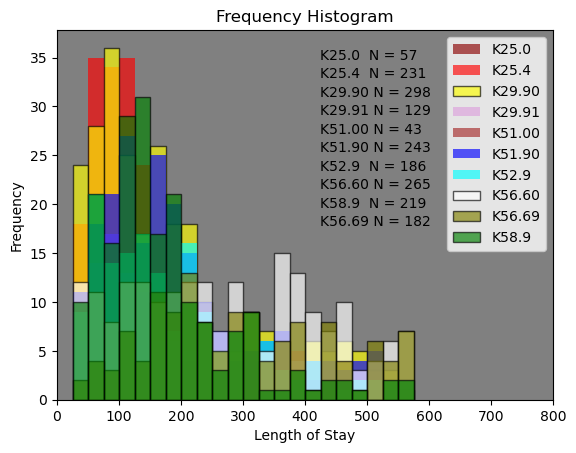

In [41]:
# Plot stay times for each admision by diagnosis code
pd.set_option('display.max_rows', 50)
# intestinal_adms[1:5]
intestinal_adms = intestinal_adms.dropna(subset='primary_icd10_code')
x1 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K25.0'), 'stay_hours']
x2 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K25.4'), 'stay_hours']
x3 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K29.90'), 'stay_hours']
x4 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K29.91'), 'stay_hours']
x5 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K51.00'), 'stay_hours']
x6 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K51.90'), 'stay_hours']
x7 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K52.9'), 'stay_hours']
x8 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K56.60'), 'stay_hours']
x9 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K56.69'), 'stay_hours']
x10 = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains('K58.9'), 'stay_hours']

abins = range(25,600,25)
kwargs = dict(alpha=0.65, bins=abins)
ax = plt.axes(alpha=0)
ax.set_facecolor("grey")
plt.hist(x1, **kwargs, color='darkred', label='K25.0')
plt.hist(x2, **kwargs, color='red', label='K25.4')
plt.hist(x3, **kwargs, color='yellow', edgecolor='black',label='K29.90')
plt.hist(x4, **kwargs, color='plum', label='K29.91')
plt.hist(x5, **kwargs, color='brown', label='K51.00')
plt.hist(x6, **kwargs, color='blue', label='K51.90')
plt.hist(x7, **kwargs, color='cyan', label='K52.9')
plt.hist(x8, **kwargs, color='white', edgecolor='black',label='K56.60')
plt.hist(x9, **kwargs, color='olive', edgecolor='black',label='K56.69')
plt.hist(x10, **kwargs, color='green', edgecolor='black',label='K58.9')


atext = 'K25.0  N = ' + str(len(x1))
btext = 'K25.4  N = ' + str(len(x2))
ctext = 'K29.90 N = ' + str(len(x3))
dtext = 'K29.91 N = ' + str(len(x4))
etext = 'K51.00 N = ' + str(len(x5))
ftext = 'K51.90 N = ' + str(len(x6))
gtext = 'K52.9  N = ' + str(len(x7))
htext = 'K56.60 N = ' + str(len(x8))
itext = 'K56.69 N = ' + str(len(x9))
jtext = 'K58.9  N = ' + str(len(x10))

ax.text(0.53, 0.95,atext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.90, btext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.85, ctext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.80, dtext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.75, etext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.70, ftext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.65, gtext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.60, htext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.55, jtext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.50, itext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)

#plt.gca().set(title='Frequency Histogram of Diamond Depths', ylabel='Frequency')
#plt.hist(wanted_admissions['stay_hours'], bins=abins)
plt.gca().set(title='Frequency Histogram', ylabel='Frequency', xlabel='Length of Stay');
plt.xlim(0,800)
plt.legend();
# plt.show()

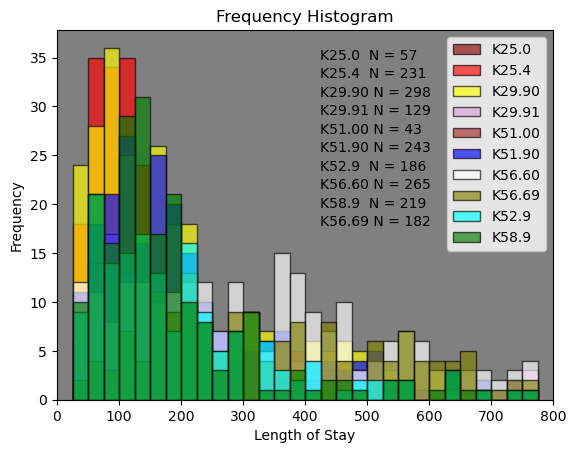

In [47]:
# Plot stay times for each admision by diagnosis code
pd.set_option('display.max_rows', 50)
# intestinal_adms[1:5]
intestinal_adms = intestinal_adms.dropna(subset='primary_icd10_code')

icd_codes2 = {'K25.0':['Acute Gastric Ulcer', 'darkred'],'K25.4':['Unspecified Chronic Gastric Ulcer','red'],
             'K29.90':['Gastroduodenitis','yellow'],'K29.91':['Unspecified Gastritis','plum'],
             'K51.00':['Universal or Chronic Ulcerative Colitis','brown'],'K51.90':['Unspecified Ulcerative Colitis','blue'],
             'K56.60':['Unspecified Intestinal Obstruction','white'], 'K56.69':['Other Specified Intestinal Obstruction','olive'], 
             'K52.9':['Unspecified Gastroenteritis','cyan'],'K58.9':['Iterable Bowel Syndrome','green']}

abins = range(25,800,25)
kwargs = dict(alpha=0.65, bins=abins)
ax = plt.axes(alpha=0)
ax.set_facecolor("grey")

temp_vert = 100

for code, description in icd_codes2.items():
    
    temp_x = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains(code), 'stay_hours']
    ax.hist(temp_x, **kwargs, color=description[1], edgecolor='black', label=code)
    temp_text = ' N = ' + str(len(temp_x))
    temp_vert -= 2
#    ax.text(0.5, temp_vert, temp_text, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)

atext = 'K25.0  N = ' + str(len(x1))
btext = 'K25.4  N = ' + str(len(x2))
ctext = 'K29.90 N = ' + str(len(x3))
dtext = 'K29.91 N = ' + str(len(x4))
etext = 'K51.00 N = ' + str(len(x5))
ftext = 'K51.90 N = ' + str(len(x6))
gtext = 'K52.9  N = ' + str(len(x7))
htext = 'K56.60 N = ' + str(len(x8))
itext = 'K56.69 N = ' + str(len(x9))
jtext = 'K58.9  N = ' + str(len(x10))

ax.text(0.53, 0.95,atext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.90, btext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.85, ctext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.80, dtext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.75, etext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.70, ftext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.65, gtext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.60, htext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.55, jtext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)
ax.text(0.53, 0.50, itext, horizontalalignment='left', verticalalignment='top',transform=ax.transAxes)

plt.gca().set(title='Frequency Histogram', ylabel='Frequency', xlabel='Length of Stay');
plt.xlim(0,800)
plt.legend();
plt.show()

<div class="alert alert-block alert-success"><font color="black"><h2><left>Examine Largest Diagnosis Codes in Side-By-Side Charts</left>
</h2></font>

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(25,600,25)
kwargs = dict(alpha=0.65, bins=abins)

axis[0,0].hist(x1,bins=100)
axis[0,0].set_xlim(0,800)
axis[0,0].set_title("K25.0 Acute Gastric Ulcer")
axis[0,0].set_ylabel('Frequency')

axis[0,1].hist(x2,bins=100)
axis[0,1].set_xlim(0,800)
axis[0,1].set_title("K25.4 Unspecified Chronic Gastric Ulcer")
# axis[3,0].set_ylabel('Frequency')

axis[1,0].hist(x3,bins=100)
axis[1,0].set_xlim(0,800)
axis[1,0].set_title("K29.90 Gastroduodenitis")
axis[1,0].set_ylabel('Frequency')

axis[1,1].hist(x4,bins=100)
axis[1,1].set_xlim(0,800)
axis[1,1].set_title("K29.91 Unspecified Gastritis")
# axis[0,1].set_ylabel('Frequency')

axis[2,0].hist(x5,bins=100)
axis[2,0].set_xlim(0,1000)
axis[2,0].set_title("K51.00 Universal or Chronic Ulcerative Colitis")
axis[2,0].set_ylabel('Frequency')

axis[2,1].hist(x6,bins=100)
axis[2,1].set_xlim(0,800)
axis[2,1].set_title("K51.90 Unspecified Ulcerative Colitis")
# axis[2,0].set_ylabel('Frequency'),bins=100

axis[3,0].hist(x8,bins=100)
axis[3,0].set_xlim(0,800)
axis[3,0].set_title("K56.60 Unspecified Intestinal Obstruction")
axis[3,0].set_ylabel('Frequency')

axis[3,1].hist(x9,bins=100)
axis[3,1].set_xlim(0,800)
axis[3,1].set_title("K56.69 Other Specified Intestinal Obstruction")
# axis[1,1].set_ylabel('Frequency')

axis[4,0].hist(x7,bins=100)
axis[4,0].set_xlim(0,800)
axis[4,0].set_title("K52.9 Unspecified Gastroenteritis")
axis[4,0].set_ylabel('Frequency')

axis[4,1].hist(x10,bins=100)
axis[4,1].set_xlim(0,800)
axis[4,1].set_title("K58.9 Iterable Bowel Syndrome")
# axis[3,1].set_ylabel('Frequency')

<div class="alert alert-block alert-success"><font color="black"><h2><left>Simplify Side-By-Side Charts Logic</left>
</h2></font>

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(25,600,25)
kwargs = dict(alpha=0.65, bins=abins)



icd_codes = {'K25.0':'Acute Gastric Ulcer','K25.4':'Unspecified Chronic Gastric Ulcer',
             'K29.90':'Gastroduodenitis','K29.91':'Unspecified Gastritis',
             'K51.00':'Universal or Chronic Ulcerative Colitis','K51.90':'Unspecified Ulcerative Colitis',
             'K56.60':'Unspecified Intestinal Obstruction', 'K56.69':'Other Specified Intestinal Obstruction', 
             'K52.9':'Unspecified Gastroenteritis','K58.9':'Iterable Bowel Syndrome'}

x_row = 0
x_col = 0

for code, description in icd_codes.items():
    
    temp_x = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains(code), 'stay_hours']
    
    atext = 'N = ' + str(len(temp_x))
    axis[x_row,x_col].hist(temp_x, bins=100)
    axis[x_row,x_col].set_xlim(0,800)
    xtitle = code + ' ' + description
    axis[x_row,x_col].text(0.8, 0.95, atext, horizontalalignment='right', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].set_title(xtitle)
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Frequency')
        x_col += 1
    else:
        x_row += 1
        x_col = 0
        
        

<div class="alert alert-block alert-success"><font color="black"><h2><left>Examine Largest Diagnosis Codes Boxplots</left>
</h2></font>

In [ ]:

fig = plt.figure(figsize =(15, 10))
ax = fig.add_subplot(111)
 
def get_data(code):
    
    temp_x = intestinal_adms.loc[intestinal_adms['primary_icd10_code'].str.contains(code), 'stay_hours']
    return temp_x

icd_codes = {'K25.0':'Acute Gastric Ulcer','K25.4':'Unspecified Chronic Gastric Ulcer',
             'K29.90':'Gastroduodenitis','K29.91':'Unspecified Gastritis',
             'K51.00':'Universal or Chronic Ulcerative Colitis','K51.90':'Unspecified Ulcerative Colitis',
             'K56.60':'Unspecified Intestinal Obstruction', 'K56.69':'Other Specified Intestinal Obstruction', 
             'K52.9':'Unspecified Gastroenteritis','K58.9':'Iterable Bowel Syndrome'}


x_data = []
x_description = []
x_items = 0

for code, description in icd_codes.items():
    
    x_description.append(description)
    x_data.append(get_data(code))
    

# Creating axes instance
bp = ax.boxplot(x_data, patch_artist = True,
                notch ='True', vert = 0)

ax.set_yticklabels(x_description)



In [ ]:
#intestinal_adms.columns
ethnicity_adms = intestinal_adms[['ethnicity','primary_icd10_code']].groupby(['ethnicity','primary_icd10_code'])\
                                                                    .size().reset_index(name='Total')\
                                                                    .sort_values('Total', ascending=False)
#df.groupby(["Group", "Size"]).size().reset_index(name="Time").sort_values()
ethnicity_adms

In [ ]:
ethnicity_adms = intestinal_adms[['ethnicity','primary_icd10_code']].groupby(['ethnicity','primary_icd10_code'])\
                                                                    .agg(counts=(('ethnicity','primary_icd10_code'),'count'))
 #                                                                  .sort_values('counts', ascending=False)
 # .agg(counts = 'count')\

ethnicity_adms[1:10]

<div class="alert alert-block alert-success"><font color="black"><h2><left>Compare the LOS for Emergency vs Elective</left>
</h2></font>

In [ ]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(25,800,25)
kwargs = dict(alpha=0.65, bins=abins)


icd_codes = {'K25.0':'Acute Gastric Ulcer','K25.4':'Unspecified Chronic Gastric Ulcer',
             'K29.90':'Gastroduodenitis','K29.91':'Unspecified Gastritis',
             'K51.00':'Universal or Chronic Ulcerative Colitis','K51.90':'Unspecified Ulcerative Colitis',
             'K56.60':'Unspecified Intestinal Obstruction', 'K56.69':'Other Specified Intestinal Obstruction', 
             'K52.9':'Unspecified Gastroenteritis','K58.9':'Iterable Bowel Syndrome'}

x_row = 0
x_col = 0

for code, description in icd_codes.items():
    
    xm = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
    (intestinal_adms['admission_type'] == 'EMERGENCY'),'stay_hours']
    xs = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
    (intestinal_adms['admission_type'] != 'EMERGENCY'),'stay_hours']
    emn = len(xm)
    eln = len(xm)
    atext = 'EM-N = ' + str(len(xm))
    btext = 'EL-N  = ' + str(len(xs))
    
    axis[x_row,x_col].hist(xm, **kwargs, color='blue', edgecolor='black',label='EMERGENCY')
    axis[x_row,x_col].hist(xs, **kwargs, color='yellow', edgecolor='black',label='NOT EMERGENCY')
    xtitle = code + ' ' + description
    axis[x_row,x_col].text(0.35, 0.95, atext, horizontalalignment='center', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.34, 0.85, btext, horizontalalignment='center', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].legend(fontsize="8")
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].margins(0,0.35)    
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Frequency')
        x_col += 1
    else:
        x_row += 1
        x_col = 0
    
35

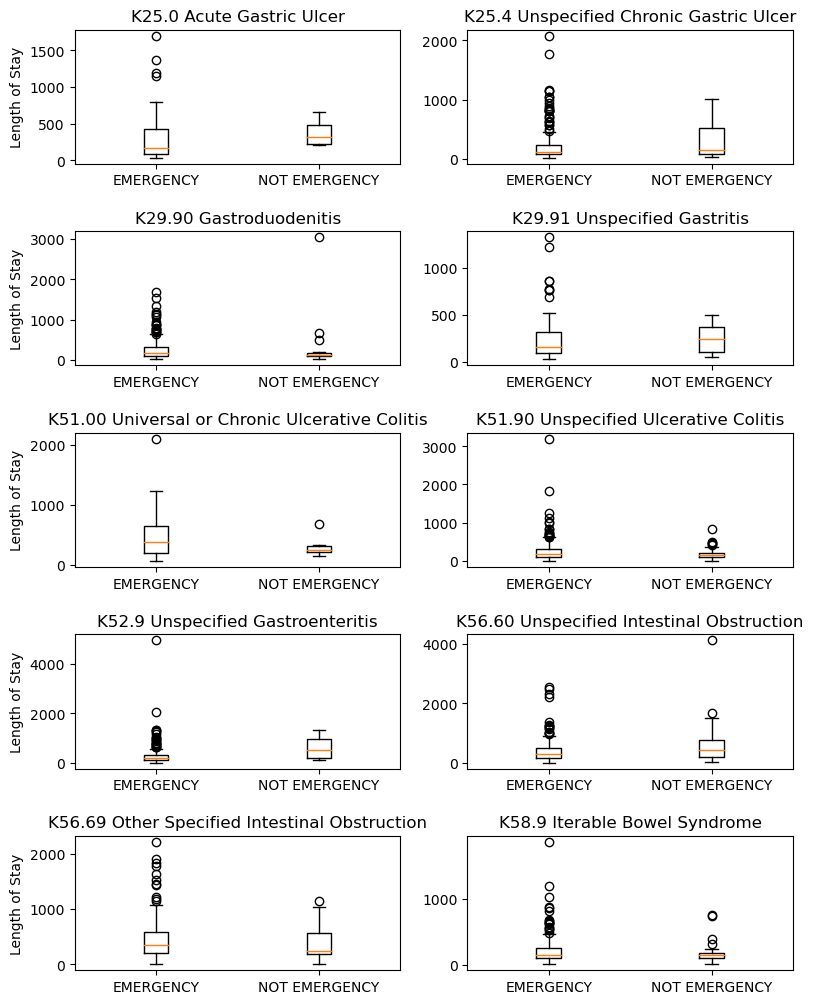

In [48]:
figure, axis = plt.subplots(nrows=5, ncols=2, figsize=(8, 10))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
# abins = range(25,800,25)
# kwargs = dict(alpha=0.65, bins=abins)



icd_codes = {'K25.0':'Acute Gastric Ulcer','K25.4':'Unspecified Chronic Gastric Ulcer',
             'K29.90':'Gastroduodenitis','K29.91':'Unspecified Gastritis',
             'K51.00':'Universal or Chronic Ulcerative Colitis','K51.90':'Unspecified Ulcerative Colitis',
             'K52.9':'Unspecified Gastroenteritis','K56.60':'Unspecified Intestinal Obstruction', 
             'K56.69':'Other Specified Intestinal Obstruction', 'K58.9':'Iterable Bowel Syndrome'}

x_row = 0
x_col = 0

for code, description in icd_codes.items():
    
    temp_xm = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
                        (intestinal_adms['admission_type'] == 'EMERGENCY'),'stay_hours']
    temp_xs = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
                        (intestinal_adms['admission_type'] != 'EMERGENCY'),'stay_hours']
    temp_data = [temp_xm, temp_xs]
    axis[x_row,x_col].boxplot(temp_data)
    xtitle = code + ' ' + description
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].set_xticklabels(['EMERGENCY', 'NOT EMERGENCY'])
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Length of Stay')
        x_col += 1
    else:
        x_row += 1
        x_col = 0


In [49]:
def set_ethnic_group(ethnicity):
    if 'WHITE' in ethnicity:
        return 'W'
    elif 'BLACK' in ethnicity:
        return 'B'
    elif 'UNKNOWN' in ethnicity:
        return 'U'
    elif 'DECLINE' in ethnicity:
        return 'U'
    elif 'UNABLE' in ethnicity:
        return 'U'
    elif 'ASIAN' in ethnicity:
        return 'A'
    elif 'HISPANIC' in ethnicity:
        return 'H'
    elif 'NATIVE' in ethnicity:
        return 'I'
    elif 'CARIBBEAN' in ethnicity:
        return 'I'
    elif 'AMERICAN INDIAN' in ethnicity:
        return 'I'
    elif 'PORTUGUESE' in ethnicity:
        return 'W'
    elif 'MIDDLE EASTERN' in ethnicity:
        return 'M'
    elif 'SOUTH AMERICAN' in ethnicity:
        return 'W'
    else:
        return 'O'


# df['add'] = df.apply(lambda row : add(row['A'], row['B'], row['C']), axis = 1)    
intestinal_adms['ethnic_group'] = intestinal_adms.apply(lambda row: set_ethnic_group(row['ethnicity']), axis = 1)


In [50]:
intestinal_adms.groupby(['ethnic_group','ethnicity'])['hadm_id'].count() 

ethnic_group  ethnicity                                        
A             ASIAN                                                 126
              ASIAN - ASIAN INDIAN                                   16
              ASIAN - CAMBODIAN                                       4
              ASIAN - CHINESE                                        41
              ASIAN - FILIPINO                                        2
              ASIAN - JAPANESE                                        2
              ASIAN - KOREAN                                          1
              ASIAN - OTHER                                           4
              ASIAN - THAI                                            1
              ASIAN - VIETNAMESE                                     11
B             BLACK/AFRICAN                                           7
              BLACK/AFRICAN AMERICAN                                912
              BLACK/CAPE VERDEAN                                     29


In [51]:
# Testing Ethnicity
ethnicity_adms = intestinal_adms.groupby('ethnic_group').size().reset_index(name='Total')\
                                                        .sort_values('Total', ascending=False)
ethnicity_adms

#temp_xm = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
#                        (intestinal_adms['admission_type'] == 'WHITE'),'stay_hours']
#temp_xs = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
#                        (intestinal_adms['admission_type'] != 'WHITE'),'stay_hours']


,ethnic_group,Total
7,W,7541
1,B,971
6,U,784
2,H,346
5,O,215
0,A,208
3,I,12
4,M,5


35

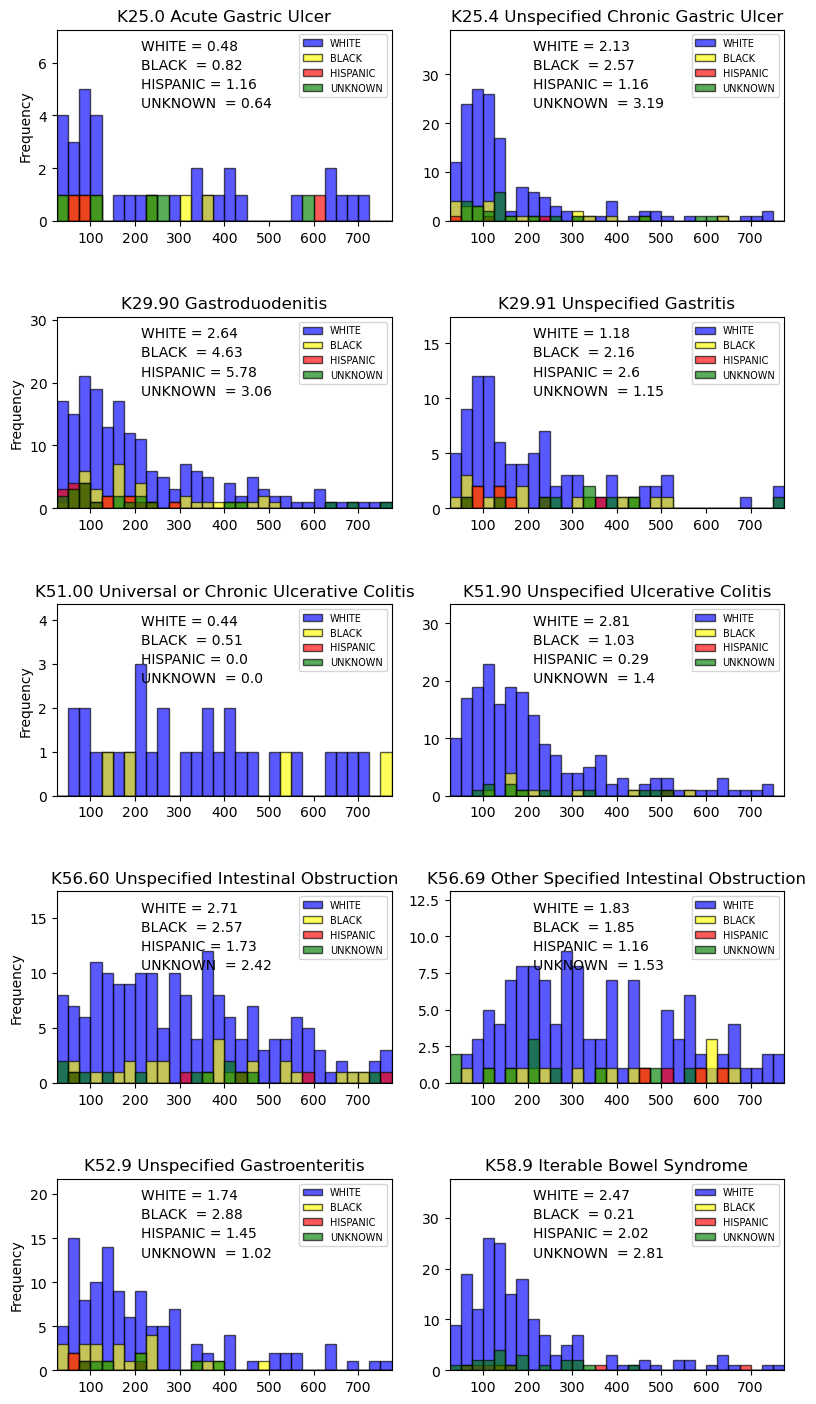

In [52]:
# Initialise the subplot function using number of rows and columns
figure, axis = plt.subplots(nrows=5, ncols=2, figsize=(8, 14))
figure.tight_layout() # Or equivalently,  "plt.tight_layout()"
plt.subplots_adjust(hspace=0.5)
  
# Default values for all plots
abins = range(25,800,25)
kwargs = dict(alpha=0.65, bins=abins)

icd_codes = {'K25.0':'Acute Gastric Ulcer','K25.4':'Unspecified Chronic Gastric Ulcer',
             'K29.90':'Gastroduodenitis','K29.91':'Unspecified Gastritis',
             'K51.00':'Universal or Chronic Ulcerative Colitis','K51.90':'Unspecified Ulcerative Colitis',
             'K56.60':'Unspecified Intestinal Obstruction', 'K56.69':'Other Specified Intestinal Obstruction', 
             'K52.9':'Unspecified Gastroenteritis','K58.9':'Iterable Bowel Syndrome'}

x_row = 0
x_col = 0

for code, description in icd_codes.items():
        
    temp_xw = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'W'),'stay_hours']
    temp_xb = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'B'),'stay_hours']
    temp_xh = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'H'),'stay_hours']
    temp_xu = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
                        (intestinal_adms['ethnic_group'] == 'U'),'stay_hours']
  #  temp_xo = intestinal_adms.loc[(intestinal_adms['primary_icd10_code'].str.contains(code)) &
  #                      (intestinal_adms['ethnic_group'] in ['O','A','I','M']),'stay_hours']
    
    wn = len(temp_xw)
    bn = len(temp_xb)
    hn = len(temp_xh)
    un = len(temp_xu)
  #  on = len(temp_xo)
    
    twn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'W')])
    tbn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'B')])
    thn = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'H')])
    tun = len(intestinal_adms.loc[(intestinal_adms['ethnic_group'] == 'U')])
     
    atext = 'WHITE = ' + str(round((len(temp_xw)/twn)*100,2))
    btext = 'BLACK  = ' + str(round((len(temp_xb)/tbn)*100,2))
    ctext = 'HISPANIC = ' + str(round((len(temp_xh)/thn)*100,2))
    dtext = 'UNKNOWN  = ' + str(round((len(temp_xu)/tun)*100,2))
 #   etext = 'OTHER = ' + str(len(temp_xo))
    
     
    axis[x_row,x_col].hist(temp_xw, **kwargs, color='blue', edgecolor='black',label='WHITE')
    axis[x_row,x_col].hist(temp_xb, **kwargs, color='yellow', edgecolor='black',label='BLACK')
    axis[x_row,x_col].hist(temp_xh, **kwargs, color='red', edgecolor='black',label='HISPANIC')
    axis[x_row,x_col].hist(temp_xu, **kwargs, color='green', edgecolor='black',label='UNKNOWN')
   # axis[x_row,x_col].hist(temp_xo, **kwargs, color='purple', edgecolor='black',label='OTHER')
    xtitle = code + ' ' + description
    axis[x_row,x_col].text(0.25, 0.95, atext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.85, btext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.75, ctext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    axis[x_row,x_col].text(0.25, 0.65, dtext, horizontalalignment='left', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    # axis[x_row,x_col].text(0.35, 0.55, etext, horizontalalignment='center', verticalalignment='top', transform=axis[x_row,x_col].transAxes)
    
    axis[x_row,x_col].legend(fontsize="7")
    axis[x_row,x_col].set_title(xtitle)
    axis[x_row,x_col].margins(0,0.45)    
    if x_col == 0:
        axis[x_row,x_col].set_ylabel('Frequency')
        x_col += 1
    else:
        x_row += 1
        x_col = 0
    
35

In [ ]:
# patients with more than one admission
# 10% intestinal folks have more than one admission
gt2admin = intestinal_adms.groupby(['subject_id', ])['hadm_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)

counts = gt2admin.loc[gt2admin['count'] > 1]['count']
print('totals: ', sum(gt2admin['count']), ' number: ', len(counts))

In [ ]:
# Count admissions by primary diagnosis
icd10_counts = intestinal_adms.groupby(['primary_icd9_code','primary_icd10_code'])['hadm_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)
icd10_count_details = pd.merge(icd10_counts, diag_codes, left_on='primary_icd9_code', right_on='icd9_code',)\
                      [['primary_icd10_code', 'icd9_code', 'long_title', 'count']]
print('total admissions: ', sum(icd10_count_details['count']), ' total codes: ', icd10_count_details.shape[0])
icd10_count_details[1:20]

In [ ]:
# Read in Notes and Join wanted_admissions with notes
# 
notes = pd.read_parquet(file4,engine='auto',use_nullable_dtypes=True)
intsl_notes = pd.merge(intestinal_adms, notes, on=['subject_id', 'hadm_id'])
intsl_notes.columns

#intsl_notes[1:10]

In [ ]:
# Add a note length column for later statistics. This is prior to cleanup of data.
# https://www.delftstack.com/howto/python-pandas/apply-function-to-column-pandas/
intsl_notes['note_length'] = intsl_notes['text'].apply(len)
intsl_notes[0:5][['hadm_id','note_length']]

In [ ]:
#Generate note counts (for all note categories) stats by diagnosis per admision (An admission has many notes during stay)
# count notes by admissoon
notes_by_diagnoses = intsl_notes.groupby(['hadm_id','primary_icd9_code' ])['row_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)
# generate stats by diagnosis for the previously counted notes 
stats_by_diagnoses = notes_by_diagnoses[['primary_icd9_code', 'count']].groupby(['primary_icd9_code' ])\
                                       .agg({'count':['min','mean', 'max']}).round(1)
# Add icd9 descriptions to summary stats
stats_by_diagnoses_details = pd.merge(stats_by_diagnoses, diag_codes, left_on='primary_icd9_code', right_on='icd9_code')\
                                     [['icd9_code', 'long_title', ('count','min'), ('count','mean'), ('count','max')]] \
                              .sort_values([('count','max')], ascending=False)
stats_by_diagnoses_details[0:30]

In [ ]:
# generate overal stats  for the previously counted notes (for all note categories)
overall_stats = notes_by_diagnoses[['hadm_id', 'count']].agg({'count':['min','mean', 'max']}).round(1)
# Add icd9 descriptions to summary stats
overall_stats[0:30]


In [ ]:
# find note counts by category 
gNotesDF = intsl_notes.groupby(['category', ])['row_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)
gNotesDF

<div class="alert alert-block alert-success"><font color="black"><h1><left>Note Sizes and Counts By Diagnosis Code</left></h1></font></div>

In [ ]:
#find min, mean, and max of note size per diagnosis prior to cleanup work
lnotes = intsl_notes.groupby(['primary_icd10_code']).agg({'note_length':['min','mean', 'max', 'count']}).round(1)
lnotes

In [ ]:
import re

regex1 = r"\[.+?\]"
regex2 = r"\[\*\*\d{4}-\d{1,2}-\d{1,2}\*\*\]"
pattern = re.compile(r"\[\*\*\d{4}-\d{1,2}-\d{1,2}\*\*\]")


def check_expression(str):
    
    print('string: ', len(str))
    
    examples = re.findall(regex1, str)
    print('Examples count: ', len(examples))
    if len(examples) == 0:
        return(False)
    
    for n in (0, len(examples)-1):
        print(n, examples[n])
        if pattern.match(examples[n]):
            examples[n] = None
    
    res = [i for i in examples if i is not None]
    
    if len(res) > 0:
        return(True)
    else:
        return(False)

examples = [note for note in intsl_notes['text'] if note != None and check_expression(note)]
examples[1:5]

In [ ]:
# Filter focus to only Physician and Nursing notes
# Cleanup notes by removing special characters
# I neecd to reword thisd. Look for extra code
#  and fix message below about clean note

def clean_note(note_data):
    regex1 = r'[ ]{2,20}'
    regex = r"\[\*\*.+\]"
    regex2 = r"[^a-zA-z0-9{3,99}]"
    note_data = re.sub(regex, '', note_data)
    note_date = re.sub(r'\s{2,99}', '', note_data)
    note_data = re.sub(r'[.,\'";:?!()#%&*+-/03<=>@\[\\\]\^`{~]', '', note_data)
    note_data = re.sub(r'\n', '', note_data)
    note_data = re.sub(regex1, ' ', note_data)
    note_data = re.sub(r'[_]+', ' ', note_data)
    note_data = re.sub(regex2, ' ', note_data)
    note_data = note_data.lower()
    return note_data

PN_notes = intsl_notes[intsl_notes['category'].isin(['Nursing', 'Physician '])]
PN_notes['text'] = PN_notes['text'].apply(clean_note)
# PN_notes['note_length'] = PN_notes['text'].apply(len)
# PN_notes['text'] = PN_notes['text'].apply(clean_note)

# sum note lenght for whole admission after cleanup
# PN_note_length = PN_notes.groupby(['hadm_id','primary_icd9_code' ])['note_length'].sum().reset_index(name='sum') 
# generate note length stats for each admision by diagnosis after cleanup 
note_stats_by_diagnosis = PN_note_length[['primary_icd9_code', 'sum']].groupby(['primary_icd9_code' ])\
                                       .agg({'sum':['min','mean', 'max'], }).round(1)\
                                       .sort_values(['primary_icd9_code'], ascending=True)
note_stats_by_diagnosis

In [ ]:
# Determine how many patients had physicina and nursing notes
admiss = PN_notes['hadm_id']
unad = set(admiss)
len(unad)
PN_admiss = PN_notes[['hadm_id','primary_icd9_code']].drop_duplicates()
PN_icd9_counts = PN_admiss.groupby(['primary_icd9_code'])['hadm_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)
PN_icd9_count_details = pd.merge(PN_icd9_counts, diag_codes, left_on='primary_icd9_code', right_on='icd9_code',)\
                      [['icd9_code', 'long_title', 'count']]
print('total admissions: ', sum(PN_icd9_count_details['count']), ' total codes: ', PN_icd9_count_details.shape[0])
PN_icd9_count_details

In [ ]:
PN_notes.columns

In [ ]:
PN_notes = vest_notes[vest_notes['category'].isin(['Nursing', 'Physician '])]
PN_notes.columns

In [ ]:
# Move this to other notebook
#def divide_1000(nl):
#    return nl/1000

icd9_dict = {'3545':'G58.7', '3548':'G58.0', '3549':'G56.9', '3558':'G57.90','3559':'G58.9','3570':'G61.0', 
                     '3868':'H81.8x', '3869':'H81.90', '7234':'M54.12', '7244':'M54.14','7292':'M54.10', 
                     '35579':'G57.80', '35781':'H61.81', '37730':'H46.9', '37739':'H46.8', '37952':'H55.02', 
                     '37955':'H55.04', '37956':'H55.09', '38610':'H81.391', '38611':'H81.10', '38612':'H81.20', 
                     '38619':'H81.311', '43885':'I69.998'}
PN_note_length['primary_icd10_code'] = PN_note_length['primary_icd9_code'].apply(lambda x: icd9_dict.get(x)) 
x1 = PN_note_length.loc[PN_note_length['primary_icd10_code'].str.contains('H'), 'sum']
x2 = PN_note_length.loc[PN_note_length['primary_icd10_code'].str.contains('G'), 'sum']
x3 = PN_note_length.loc[PN_note_length['primary_icd10_code'].str.contains('M'), 'sum']
x4 = PN_note_length.loc[PN_note_length['primary_icd10_code'].str.contains('I'), 'sum']
abins = range(10000,400000,10000)
kwargs = dict(alpha=0.5, bins=abins)
plt.hist(x1, **kwargs, color='g', label='H codes')
plt.hist(x2, **kwargs, color='b', label='G codes')
plt.hist(x3, **kwargs, color='m', label='M codes')
plt.hist(x4, **kwargs, color='r', label='I codes')
plt.gca().set(title='Admission Notes Length by Diagnosis Groups', ylabel='Frequency');
plt.xlim(0,)
plt.xlabel('Note Length')
plt.legend();
plt.show()

In [ ]:
# Check that special character cleanup worked
regex = r"(([^a-zA-z0-9]{3,99})|([_]{5,30}))"
extra_text = PN_notes['text'].str.match(regex,flags=re.IGNORECASE)
#extra_text.shape[0]
extra_text.value_counts()

In [ ]:
#Generate individual note counts stats by diagnosisi for Physician and Nursing Notes
# count notes by admissoon
notes_by_diagnoses = PN_notes.groupby(['hadm_id','primary_icd9_code' ])['row_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)
# generate stats by diagnosis for the previously counted notes 
stats_by_diagnoses = notes_by_diagnoses[['primary_icd9_code', 'count']].groupby(['primary_icd9_code' ])\
                                       .agg({'count':['min','mean', 'max']}).round(1)
# Add icd9 descriptions to summary stats
stats_by_diagnoses_details = pd.merge(stats_by_diagnoses, diag_codes, left_on='primary_icd9_code', right_on='icd9_code')\
                                [['icd9_code', 'long_title', ('count','min'), ('count','mean'), ('count','max')]] \
                              .sort_values(['icd9_code'], ascending=True)
stats_by_diagnoses_details['icd9_code'] = pd.to_numeric(stats_by_diagnoses_details.icd9_code.str.strip())
#sort notes by icd9 code
sorted_df = stats_by_diagnoses_details.sort_values([('icd9_code')], ascending=True)
sorted_df


In [ ]:
def write_notes_parquet(outfile, df):
    
    print('writing parquet')
    df.to_parquet(outfile, compression='snappy', index=None)  
    
    print('parquet file written')
    return

write_notes_parquet(file9, PN_notes)

In [ ]:
# Get Chart Events
cevents.columns

In [ ]:
ceventsGp = cevents.groupby(['category', ])['row_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)
ceventsGp

In [ ]:
some_notes = vest_notes[vest_notes['category'] == 'Radiology']

In [ ]:
some_notes[0:3]['text']

In [ ]:
# This code groups patients notes by admission (hadm_id) and finds min, max, and avg per admisison
import numpy as np
print ('vest_count: ', vest_notes.shape[0], ' notes count: ', notes.shape[0])
#groupedDF = notes.groupby(['hadm_id', 'subject_id'])['row_id'].count() \

groupedDF = notes.groupby(['hadm_id', 'subject_id'])['row_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)              
print('max: ', np.max(groupedDF['count']), ' min: ', np.min(groupedDF['count']),
      ' mean: ', np.mean(groupedDF['count']), ' median: ', np.median(groupedDF['count']))
#np.max(groupedDF['count'])
#np.min(groupedDF['count'])
#np.mean(groupedDF['count'])
#np.median(groupedDF['count'])
groupedDF[0:10]

In [ ]:
# This function takes in a list of notes for the same admission and combines them

def combine_notes(tlist):
    
    temp_notes = ' '
    for note in tlist: 
        temp_notes += note
        
    return temp_note
df.agg({'Col_A' : ['sum', 'min'], 
        'Col_B' : ['min', 'max']})
gNotesDF = notes.groupby(['hadm_id', 'subject_id', ])['row_id'].count() \
              .reset_index(name='count') \
              .sort_values(['count'], ascending=False)       

In [ ]:
print('start note count: ', notes.count())
#notes[notes['row_id'] == 357928].count()
notes2 = notes.drop_duplicates(keep='first')
print('end note count: ', notes2.count())
notes2[notes['row_id'] == 357928].count()

In [ ]:
# Count total patients
patients = wr.s3.read_parquet(path='s3://depratti-masters-thesis/MIMIC/PATIENTS/part-00000-d13867a4-14ff-4f48-9e4a-d3867f4d7a12-c000.snappy.parquet')
patients.columns


In [ ]:
patients.count()

In [ ]:
path = 'D:\Education\DataScience\CCSU-Data-Science\Data-Mining-And-Predictive-Analytics\Data-531\Data\\'
file3 = path + 'part-00000-923ef113-d214-4c50-bc0a-bf6b2bd93bf1-c000.snappy.parquet'
df = pd.read_parquet(file3,engine='auto',use_nullable_dtypes=True)
df.columns
#notes.columns
print('min date', min(df['chartdate']), ' ' , 'max date: ', max(df['chartdate']))
n = df.nunique(axis=0)
print("No.of.unique values in each column :\n", n)